# Luna & IJulia scan example
27/11/23

Quick demo of `scan` from the Luna docs, see http://lupo-lab.com/Luna.jl/dev/scans.html.

Now working in Jupyter with fix per https://github.com/LupoLab/Luna.jl/issues/317 - need to clear local `ARGS` prior to scan object creation.

OK for both serial and parallel runs.

## Configure scan

In [1]:
using Luna
import PyPlot: plt

# General simulation config
a = 125e-6
flength = 3
gas = :HeJ
λ0 = 800e-9
τfwhm = 10e-15
λlims = (100e-9, 4e-6)
trange = 400e-15

energies = collect(range(50e-6, 200e-6; length=5))
pressures = collect(0.6:0.4:1.4)

# Set ncores - if set =0 will run in parallel
# See http://lupo-lab.com/Luna.jl/dev/modules/Scans.html#Luna.Scans.QueueExec
ncores = 20

20

## Run scan

In [2]:
# Clear ARGS if running in Jupyter/IJulia
if isdefined(Main, :IJulia) && Main.IJulia.inited
    [pop!(ARGS) for _ in eachindex(ARGS)]
end

# Init scan object
scan = Scan("pressure_energy_example", Scans.QueueExec(ncores); energy=energies)  # Parallel, ncores=5
addvariable!(scan, :pressure, pressures)

# @__DIR__ gives the directory of the current file
outputdir = joinpath(@__DIR__, "scanoutput_parallel_demo_271123")

# Run scan
runscan(scan) do scanidx, energy, pressure
    prop_capillary(a, flength, gas, pressure; λ0, τfwhm, energy,
                   λlims, trange, scan, scanidx, filepath=outputdir)
end

      From worker 3:	┌ Info: Running scan: pressure_energy_example (15 points)
      From worker 3:	│ Index: 00001
      From worker 3:	│ Variables:
      From worker 3:	│ 	energy: 5e-05
      From worker 3:	└ 	pressure: 0.6
      From worker 3:	[ Info: X+Y polarisation not required.
      From worker 3:	[ Info: Freq limits 0.07 - 3.00 PHz
      From worker 3:	[ Info: Samples needed: 7195.02, samples: 8192, δt = 55.59 as
      From worker 3:	[ Info: Requested time window: 400.0 fs, actual time window: 455.4 fs
      From worker 3:	[ Info: Grid: samples 4096 / 8192, ωmax 2.83e+16 / 5.65e+16
      From worker 3:	[ Info: Using PPT ionisation rate.
      From worker 3:	[ Info: Found cached PPT rate for 24.588208407672 eV, 800.0 nm
      From worker 3:	[ Info: Using mode-averaged propagation.
      From worker 3:	[ Info: Found FFTW wisdom at /opt/julia/scratchspaces/30eb0fb0-5147-11e9-3356-d75b018717ce/lunacache/FFTWcache_1threads
      From worker 3:	[ Info: FFTW wisdom saved to /opt/julia

Task (done) @0x00007fad96ea8330

## Process & plot

In [3]:
λ, Iλ, zstat, edens, max_peakpower = Processing.scanproc(outputdir) do output
    λ, Iλ = Processing.getIω(output, :λ)
    zstat = Processing.VarLength(output["stats"]["z"])
    edens = Processing.VarLength(output["stats"]["electrondensity"])
    max_peakpower = maximum(output["stats"]["peakpower"])
    Processing.Common(λ), Iλ[:, end], zstat, edens, max_peakpower
end

([9.096158116811015e-8, 9.102222222222222e-8, 9.108294418501222e-8, 9.114374721851357e-8, 9.12046314851926e-8, 9.126559714795008e-8, 9.132664437012263e-8, 9.138777331548415e-8, 9.144898414824737e-8, 9.151027703306522e-8  …  5.056790123456789e-6, 5.251282051282051e-6, 5.461333333333333e-6, 5.6888888888888884e-6, 5.93623188405797e-6, 6.2060606060606046e-6, 6.5015873015873014e-6, 6.826666666666666e-6, 7.185964912280701e-6, 7.585185185185184e-6], [4.3736010038565484e-20 8.588243022287672e-19 … 1.5891247819354563e-18 7.236523984133185e-19; 4.746941304057879e-20 9.309843297652874e-19 … 1.7660320656996614e-18 8.002690430460901e-19; … ; 4.1118666115913337e-20 6.7127674970635826e-21 … 8.187400742867166e-14 7.37832530155383e-10; 3.897539308208813e-20 3.0308848909784383e-20 … 5.547559763769617e-14 6.652316373230068e-10;;; 3.756713815150586e-18 4.870323575863119e-18 … 4.510819600179124e-19 3.5035091091673895e-16; 4.1034075398588715e-18 5.344766699935715e-18 … 4.96088052832399e-19 3.851388696474759

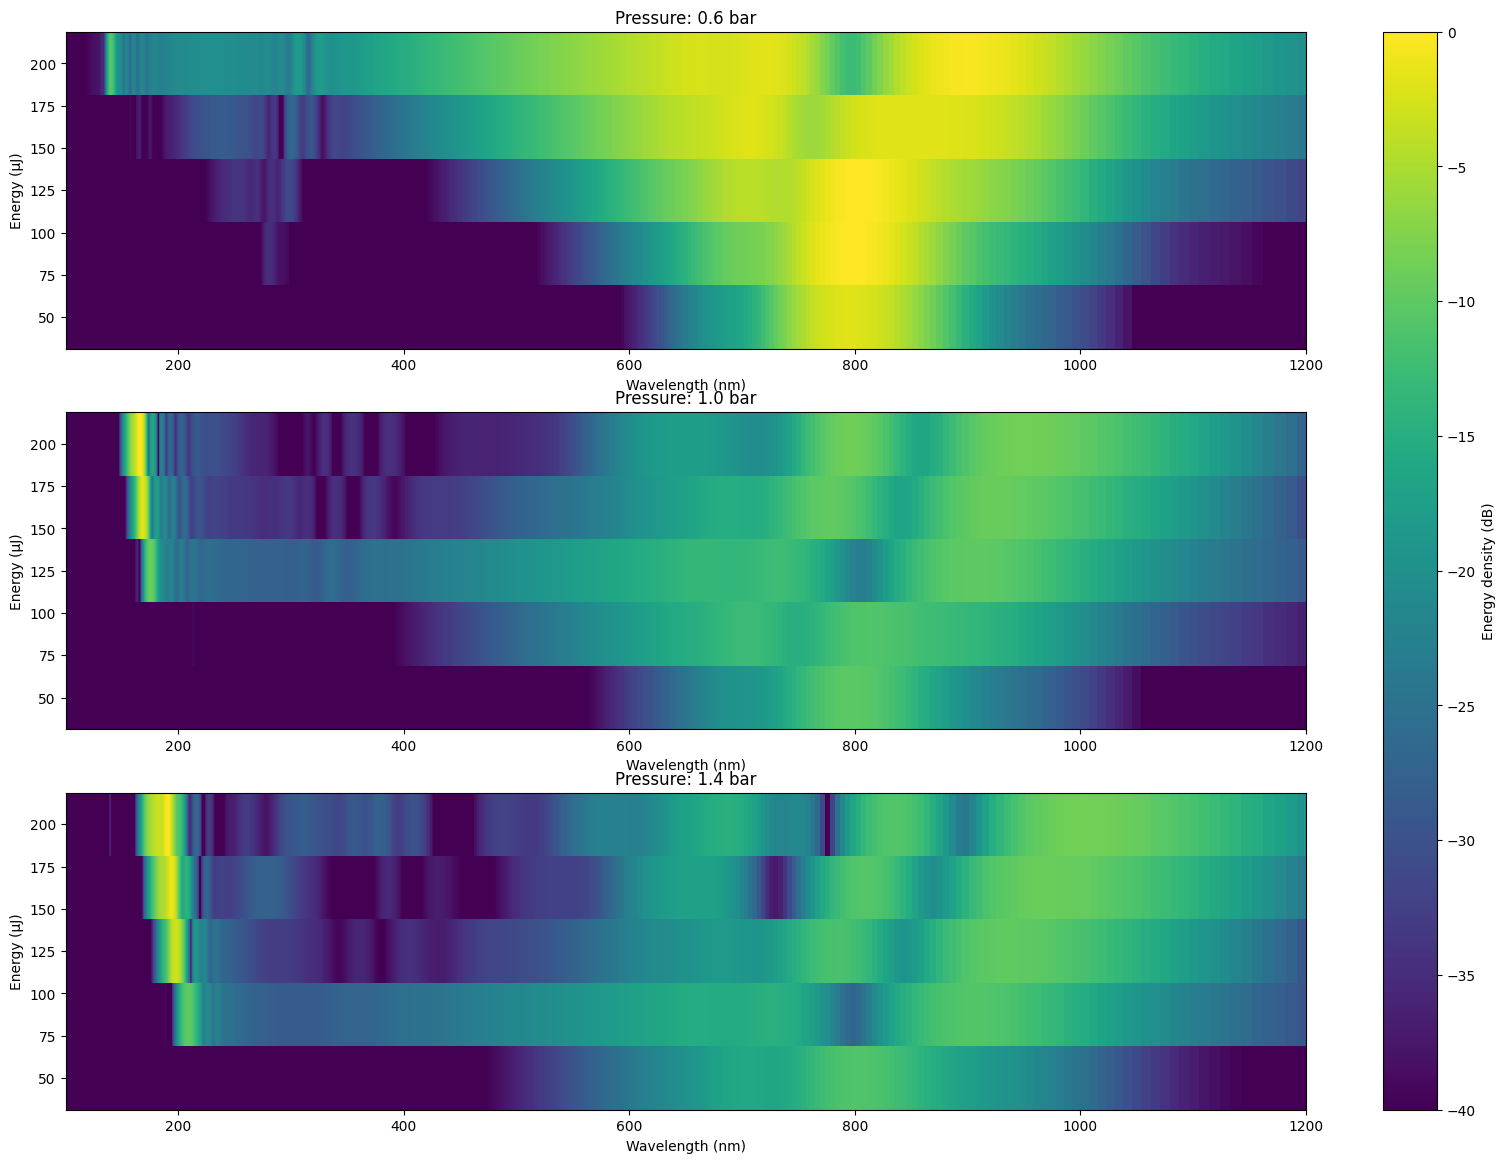

PyObject <matplotlib.colorbar.Colorbar object at 0x7fad7bf1e6e0>

In [11]:
fig, axs = plt.subplots(3, round(Int,length(pressures)/3))
fig.set_size_inches(20, 14)
for (pidx, pressure) in enumerate(pressures)
    ax = axs[pidx]
    global img = ax.pcolormesh(λ*1e9, energies*1e6, 10*Maths.log10_norm(Iλ[:, :, pidx])')
    img.set_clim(-40, 0)
    ax.set_xlabel("Wavelength (nm)")
    ax.set_ylabel("Energy (μJ)")
    ax.set_title("Pressure: $pressure bar")
    ax.set_xlim(100, 1200)
end
plt.colorbar(img, ax=axs, label="Energy density (dB)")

## Versions

In [12]:
versioninfo()

Julia Version 1.9.3
Commit bed2cd540a1 (2023-08-24 14:43 UTC)
Build Info:
  Official https://julialang.org/ release
Platform Info:
  OS: Linux (x86_64-linux-gnu)
  CPU: 56 × Intel(R) Xeon(R) CPU E5-2660 v4 @ 2.00GHz
  WORD_SIZE: 64
  LIBM: libopenlibm
  LLVM: libLLVM-14.0.6 (ORCJIT, broadwell)
  Threads: 2 on 56 virtual cores
Environment:
  JULIA_PKGDIR = /opt/julia
  JULIA_DEPOT_PATH = /opt/julia
  LD_LIBRARY_PATH = 


In [13]:
using Pkg
Pkg.status()

Status `/opt/julia/environments/v1.9/Project.toml`
  [a8cc5b0e] Crayons v4.1.1
  [a93c6f00] DataFrames v1.6.1
  [5789e2e9] FileIO v1.16.1
  [59287772] Formatting v0.4.2
⌃ [f67ccb44] HDF5 v0.17.0
  [7073ff75] IJulia v1.24.2
  [916415d5] Images v0.26.0
  [30eb0fb0] Luna v0.4.0
⌃ [c3e4b0f8] Pluto v0.19.27
  [08abe8d2] PrettyTables v2.2.8
  [d330b81b] PyPlot v2.11.2
Info Packages marked with ⌃ have new versions available and may be upgradable.
